In [ ]:
import sys
import os
import subprocess
import tarfile
import shutil
import types
import math
import pickle
import time
import tempfile
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import boda
from boda.common import utils
from boda.generator import plot_tools
from boda.generator.parameters import BasicParameters

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from statsmodels.graphics.tsaplots import plot_acf

from scipy import spatial
from scipy.cluster import hierarchy


In [ ]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {left_flank.shape}')

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {right_flank.shape}')

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode
Left flanking sequence shape: torch.Size([1, 4, 200])
Left flanking sequence shape: torch.Size([1, 4, 200])


In [ ]:
def run_model(model, x):
    with torch.no_grad():
        bsz = x.shape[0]
        expander = [bsz, -1, -1]
        passthrough = BasicParameters(
            torch.randn_like(x), 
            left_flank = left_flank.expand(*expander), 
            right_flank = right_flank.expand(*expander)
        )
        passthrough.to(model.device)

        return model( passthrough(x.to(model.device)) ).cpu()

def gumsoft_sample(x, n_samples=50):
    repeater   = [ -1 for i in range(len(x.shape)) ]
    
    hook = F.gumbel_softmax(
        x.unsqueeze(0).expand(n_samples, *repeater), 
        tau=1, 
        hard=True, 
        eps=1e-10, 
        dim= -2
    )
    return hook

def overmax(y_hat, bias_cell=0, a_min=-2., a_max=6.):
    hook   = y_hat.clamp(a_min,a_max)
    energy = hook[...,[ x for x in range(hook.shape[-1]) if x != bias_cell]].max(-1).values \
               - hook[...,bias_cell]
    return energy
    
def filter_samples(x, y):
    n_samples, bsz, *_ = x.shape
    batch_slicer = torch.arange(bsz)
    y = y.unflatten(0, (n_samples,bsz))
    return {'sample': x[y.argmin(0),batch_slicer], 'energy': y[y.argmin(0),batch_slicer]}
    
def get_best_sample(model, x, n_samples=50, bias_cell=0, a_min=-2., a_max=6.):
    sample = gumsoft_sample( x, n_samples=n_samples )
    act_preds= run_model(model, sample.flatten(0,1))
    energy   = overmax( act_preds, bias_cell=bias_cell, a_min=a_min, a_max=a_max )
    results  = filter_samples(sample, energy)
    return results

def filter_trajectory(model, traj, threshold=-2, n_samples=50, bias_cell=0, a_min=-2., a_max=6.):
    traj_len, *theta_shape = traj.shape
    samples = torch.empty(0,*theta_shape, dtype=torch.float)
    energies= torch.empty(0,theta_shape[0], dtype=torch.float)
    mask    = torch.empty(0,theta_shape[0], dtype=torch.bool)
    for i in tqdm(range(traj.shape[0])):
        step = get_best_sample( model, traj[i], n_samples=n_samples, bias_cell=bias_cell, a_min=a_min, a_max=a_max )
        mask = torch.cat([mask, step['energy'].le(threshold).unsqueeze(0)], dim=0)
        energies= torch.cat([energies, step['energy'].unsqueeze(0)], dim=0)
        samples = torch.cat([samples, step['sample'].unsqueeze(0)], dim=0)
    return {'samples': samples, 'energies':energies, 'mask': mask}

In [ ]:
def save_proposals(proposals, args):
    save_dict = {
        'proposals': proposals,
        'args'     : args,
        'timestamp'    : time.strftime("%Y%m%d_%H%M%S"),
        'random_tag'   : random.randint(100000,999999)
    }
    filename = f'{args["Main args"].proposal_path}__{save_dict["timestamp"]}__{save_dict["random_tag"]}.pt'
    
    if 'gs://' in args['Main args'].proposal_path:
        torch.save(save_dict, os.path.basename(filename))
        subprocess.check_call(
            ['gsutil', 'cp', os.path.basename(filename), filename]
        )
    else:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        torch.save(save_dict, filename)
    
    print(f'Proposals deposited at:\n\t{filename}', file=sys.stderr)

def get_count_per_traj(pass_per, get_ct=500):
    for val in range(pass_per.min().item(),pass_per.max().item()+1):
        if pass_per.clamp(-1,val).sum() >= get_ct:
            break
            
    ct_per_traj = pass_per.clamp(0,val)

    remainder = max(0, ct_per_traj.sum().item() - get_ct)
    
    
    for chop in range(remainder):
        idx = ct_per_traj.argmax().item()
        ct_per_traj[ idx ] = ct_per_traj[ idx ] - 1
        
    return ct_per_traj

def down_sample_mask(mask, ct_per_traj):
    mask_copy = mask.clone().detach()
    
    traj_len, n_traj = mask_copy.shape
    for traj_id in range(n_traj):
        pass_ids = mask[:, traj_id].nonzero().flatten()
        kill_ids = pass_ids[ torch.randperm(pass_ids.numel()) ][ct_per_traj[traj_id]:]
        mask_copy[kill_ids,traj_id] = False
        
    return mask_copy
        
def mcmc_stash_to_boda_pickle(mcmc_stash, pickle_tag, model, target_count=500,
                              threshold=-2, n_samples=50, bias_cell=0, a_min=-2., a_max=6.):
    
    stash = torch.load(mcmc_stash)
    
    fil_traj = filter_trajectory(
        model, stash['samples'], 
        threshold=threshold, n_samples=n_samples, bias_cell=bias_cell, a_min=a_min, a_max=a_max
    )
    
    print(f'n samples above threshold: {fil_traj["mask"].sum()}', file=sys.stderr)
    
    counts_per_trajectory = get_count_per_traj(fil_traj['mask'].sum(0), get_ct=target_count)
    re_mask = down_sample_mask(fil_traj['mask'], counts_per_trajectory)
    
    print(f'removing {(fil_traj["mask"]^re_mask).sum().item()} samples.', file=sys.stderr)
    
    proposals = fil_traj['samples'][re_mask]
    
    print(f'proposal shape: {proposals.shape}', file=sys.stderr)
    
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    random_tag= random.randint(100000,999999)
    
    save_dict = {'proposals':[{'proposals':proposals}], 'timestamp':timestamp, 'random_tag':random_tag}
    
    filename = f'{pickle_tag}__{timestamp}__{random_tag}.pt'
    
    if 'gs://' in filename:
        with tempfile.TemporaryDirectory() as tmpdirname:
            temp_loc = os.path.join(tmpdirname, os.path.basename(filename))
            torch.save(save_dict, temp_loc)
            subprocess.check_call(
                ['gsutil', 'cp', temp_loc, filename]
            )
    else:
        if (os.path.dirname(filename) != '') and (os.path.dirname(filename) != '.'):
            os.makedirs(os.path.dirname(filename), exist_ok=True)
        torch.save(save_dict, filename)
    
    print(f'Proposals deposited at:\n\t{filename}', file=sys.stderr)

# Dump to GS

In [ ]:
for cell, c_idx in zip(['k562', 'hepg2', 'sknsh'], [0,1,2]):
    for i in range(10):
        if i < 9:
            track_tag = f'00{i+1}'
        else:
            track_tag = f'0{i+1}'
        if 'k562' == cell:
            n_samples = 10
            thresh = -3.
        elif 'hepg2' == cell:
            n_samples = 50
            thresh = -2
        else:
            n_samples = 100
            thresh = -1.8
        local_stash = f'{cell}_run_{i}.pt'
        remote_dump = f'gs://syrgoth/boda_library_design_202112/pickles/sg__{cell}__hmc__track_{track_tag}__round_0'
        print(f'transferring stash: {local_stash}')
        mcmc_stash_to_boda_pickle(local_stash, remote_dump, my_model, target_count=500, n_samples=100, threshold=thresh, bias_cell=c_idx)


transferring stash: k562_run_10.pt


FileNotFoundError: [Errno 2] No such file or directory: 'k562_run_10.pt'

In [8]:
for cell in ['hepg2', 'sknsh']:
    for i in range(10,16):
        if i < 9:
            track_tag = f'00{i+1}'
        else:
            track_tag = f'0{i+1}'
        if 'k562' == cell:
            n_samples = 10
            thresh = -3.
        elif 'hepg2' == cell:
            n_samples = 50
            thresh = -2
        else:
            n_samples = 100
            thresh = -2
        local_stash = f'{cell}_run_{i}.pt'
        remote_dump = f'gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__{cell}__hmc__track_{track_tag}__round_0'
        print(f'loading stash: {local_stash}')
        mcmc_stash_to_boda_pickle(local_stash, remote_dump, my_model, target_count=500, n_samples=100, threshold=thresh)


  0%|          | 2/1000 [00:00<01:08, 14.56it/s]

loading stash: hepg2_run_10.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.11it/s]
n samples above threshold: 321
removing 0 samples.
proposal shape: torch.Size([321, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__hepg2__hmc__track_011__round_0__20211213_141412__444669.pt
  0%|          | 2/1000 [00:00<01:08, 14.53it/s]

loading stash: hepg2_run_11.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.15it/s]
n samples above threshold: 296
removing 0 samples.
proposal shape: torch.Size([296, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__hepg2__hmc__track_012__round_0__20211213_141525__841365.pt
  0%|          | 2/1000 [00:00<01:09, 14.46it/s]

loading stash: hepg2_run_12.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s]
n samples above threshold: 342
removing 0 samples.
proposal shape: torch.Size([342, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__hepg2__hmc__track_013__round_0__20211213_141637__333762.pt
  0%|          | 2/1000 [00:00<01:09, 14.44it/s]

loading stash: hepg2_run_13.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s]
n samples above threshold: 315
removing 0 samples.
proposal shape: torch.Size([315, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__hepg2__hmc__track_014__round_0__20211213_141749__270660.pt
  0%|          | 2/1000 [00:00<01:08, 14.55it/s]

loading stash: hepg2_run_14.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s]
n samples above threshold: 332
removing 0 samples.
proposal shape: torch.Size([332, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__hepg2__hmc__track_015__round_0__20211213_141901__715602.pt
  0%|          | 2/1000 [00:00<01:08, 14.58it/s]

loading stash: hepg2_run_15.pt


100%|██████████| 1000/1000 [01:09<00:00, 14.36it/s]
n samples above threshold: 312
removing 0 samples.
proposal shape: torch.Size([312, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__hepg2__hmc__track_016__round_0__20211213_142013__546823.pt
  0%|          | 2/1000 [00:00<01:07, 14.70it/s]

loading stash: sknsh_run_10.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.17it/s]
n samples above threshold: 277
removing 0 samples.
proposal shape: torch.Size([277, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__sknsh__hmc__track_011__round_0__20211213_142125__108786.pt
  0%|          | 2/1000 [00:00<01:11, 14.02it/s]

loading stash: sknsh_run_11.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s]
n samples above threshold: 252
removing 0 samples.
proposal shape: torch.Size([252, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__sknsh__hmc__track_012__round_0__20211213_142237__606687.pt
  0%|          | 2/1000 [00:00<01:08, 14.55it/s]

loading stash: sknsh_run_12.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.13it/s]
n samples above threshold: 254
removing 0 samples.
proposal shape: torch.Size([254, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__sknsh__hmc__track_013__round_0__20211213_142349__372431.pt
  0%|          | 2/1000 [00:00<01:08, 14.61it/s]

loading stash: sknsh_run_13.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.14it/s]
n samples above threshold: 310
removing 0 samples.
proposal shape: torch.Size([310, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__sknsh__hmc__track_014__round_0__20211213_142502__650549.pt
  0%|          | 2/1000 [00:00<01:09, 14.43it/s]

loading stash: sknsh_run_14.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.16it/s]
n samples above threshold: 297
removing 0 samples.
proposal shape: torch.Size([297, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__sknsh__hmc__track_015__round_0__20211213_142614__766736.pt
  0%|          | 2/1000 [00:00<01:09, 14.40it/s]

loading stash: sknsh_run_15.pt


100%|██████████| 1000/1000 [01:10<00:00, 14.16it/s]
n samples above threshold: 304
removing 0 samples.
proposal shape: torch.Size([304, 4, 200])
Proposals deposited at:
	gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__sknsh__hmc__track_016__round_0__20211213_142726__100534.pt


# Scan results

In [17]:
for cell in ['k562', 'hepg2', 'sknsh']:
    for i in range(10):
        stash = torch.load(f'{cell}_run_{i}.pt')
        print(f'{cell} run {i}:')
        fil_traj = filter_trajectory(my_model, stash['samples'])
        print( fil_traj['mask'].sum(0) )
        print( fil_traj['mask'].sum() )
        print('')

  0%|          | 3/1000 [00:00<00:39, 24.94it/s]

k562 run 0:


  0%|          | 3/1000 [00:00<00:35, 27.75it/s]

tensor([102, 124, 150, 204, 140,  82,  61, 110,  68,  77, 165, 117,  61, 157,
        109, 151])
tensor(1878)

k562 run 1:


  0%|          | 3/1000 [00:00<00:39, 25.02it/s]

tensor([160, 114, 166, 109, 114,  88, 146,  97, 106,  76, 138,  79, 210,  57,
        129, 143])
tensor(1932)

k562 run 2:


  0%|          | 3/1000 [00:00<00:35, 28.00it/s]

tensor([145,  96,  29, 151, 188,  56, 154, 218,  80, 107, 144, 100, 146, 135,
         75, 101])
tensor(1925)

k562 run 3:


  0%|          | 3/1000 [00:00<00:35, 28.17it/s]

tensor([ 65, 167,  76, 171, 190,  76, 149, 104,  90,  85, 142, 123, 144,  38,
        118,  63])
tensor(1801)

k562 run 4:


  0%|          | 3/1000 [00:00<00:35, 28.03it/s]

tensor([ 30, 158,  57, 179,  75, 205,  50,  21,  64, 118,   7, 410,  25,  93,
        174, 132])
tensor(1798)

k562 run 5:


  0%|          | 3/1000 [00:00<00:35, 27.99it/s]

tensor([ 76, 238, 217, 128, 190,  69, 129,  47,  39, 334,  82, 137,  81,  54,
        153, 172])
tensor(2146)

k562 run 6:


  0%|          | 3/1000 [00:00<00:35, 28.02it/s]

tensor([128, 124, 160, 152, 110,  74, 193,  91,  55, 245, 195, 158,  34, 238,
        178,  90])
tensor(2225)

k562 run 7:


  0%|          | 3/1000 [00:00<00:35, 28.13it/s]

tensor([ 80,  16, 106, 159,  84, 105, 106, 132, 123, 161,  32, 153,  50, 170,
        241,  92])
tensor(1810)

k562 run 8:


  0%|          | 3/1000 [00:00<00:35, 27.87it/s]

tensor([257, 103, 165,  55, 182, 127,  38,  48, 100,  65,  49,  73,  83,  88,
         47, 131])
tensor(1611)

k562 run 9:


  0%|          | 3/1000 [00:00<00:36, 27.62it/s]

tensor([134,  82, 157,  45, 112, 106,  72, 126, 260,  86,  65,  79, 115, 143,
         99, 111])
tensor(1792)

hepg2 run 0:


  0%|          | 3/1000 [00:00<00:35, 28.05it/s]

tensor([18,  9,  4, 20, 12, 16, 17, 10, 21, 10,  2, 10,  6, 23, 13, 19])
tensor(210)

hepg2 run 1:


  0%|          | 3/1000 [00:00<00:47, 20.98it/s]

tensor([23, 36,  7, 16, 14, 17,  2, 17, 16,  5, 22, 10, 12, 10,  8, 13])
tensor(228)

hepg2 run 2:


  0%|          | 3/1000 [00:00<00:36, 27.54it/s]

tensor([15,  6, 10, 10, 16, 12, 18, 15,  7, 12,  5,  8, 25, 12, 12,  3])
tensor(186)

hepg2 run 3:


  0%|          | 3/1000 [00:00<00:47, 21.10it/s]

tensor([10, 12, 25, 15, 27, 14, 10, 21,  9,  6, 14, 12, 18,  9, 13, 19])
tensor(234)

hepg2 run 4:


  0%|          | 3/1000 [00:00<00:36, 27.06it/s]

tensor([20, 18,  4, 12, 27, 11, 10, 17, 14, 24, 13,  8, 19,  8, 12, 13])
tensor(230)

hepg2 run 5:


  0%|          | 3/1000 [00:00<00:35, 27.82it/s]

tensor([16, 16, 18, 10, 14, 12, 13,  6, 10, 10, 17, 16, 15, 20, 11,  9])
tensor(213)

hepg2 run 6:


  0%|          | 3/1000 [00:00<00:35, 28.09it/s]

tensor([10, 10, 25, 31, 16, 17,  9, 10, 14, 11, 17, 11, 22,  9, 10, 10])
tensor(232)

hepg2 run 7:


  0%|          | 3/1000 [00:00<00:35, 27.84it/s]

tensor([17, 24,  9, 12,  7, 14, 17, 23, 17, 20, 10, 16,  7, 25, 12, 21])
tensor(251)

hepg2 run 8:


  0%|          | 3/1000 [00:00<00:35, 28.19it/s]

tensor([11,  7, 10,  7, 13, 24, 11, 20, 21, 22,  6,  9,  8,  9, 17, 13])
tensor(208)

hepg2 run 9:


  0%|          | 3/1000 [00:00<00:35, 27.92it/s]

tensor([16, 28, 11, 15,  8,  4, 15, 21, 13,  9,  7, 18,  9, 14,  8, 22])
tensor(218)

sknsh run 0:


  0%|          | 3/1000 [00:00<00:35, 27.94it/s]

tensor([19, 10,  6, 25, 21,  4, 13, 15, 12, 19, 12,  9, 35, 11, 15, 11])
tensor(237)

sknsh run 1:


  0%|          | 3/1000 [00:00<00:35, 28.16it/s]

tensor([ 7, 13, 10, 10,  7,  5, 22,  6,  8, 23, 10, 13, 11, 16, 20, 15])
tensor(196)

sknsh run 2:


  0%|          | 3/1000 [00:00<00:35, 27.99it/s]

tensor([35, 10, 12, 18, 20,  5, 17, 13, 17, 11, 11, 12, 15, 18,  8,  6])
tensor(228)

sknsh run 3:


  0%|          | 3/1000 [00:00<00:35, 28.02it/s]

tensor([24, 27, 13, 22, 12, 27, 11, 10,  3, 10, 20,  8, 23, 19, 20, 28])
tensor(277)

sknsh run 4:


  0%|          | 3/1000 [00:00<00:35, 27.82it/s]

tensor([23, 12, 18,  8,  7, 21, 10, 23, 21, 14,  9, 13, 20, 15,  7, 12])
tensor(233)

sknsh run 5:


  0%|          | 3/1000 [00:00<00:39, 25.14it/s]

tensor([17,  7, 32, 10, 11, 19, 18, 29, 31, 15, 18,  6, 18, 14,  4, 10])
tensor(259)

sknsh run 6:


  0%|          | 3/1000 [00:00<00:35, 28.04it/s]

tensor([19, 20, 22, 13,  7, 13,  6, 10,  7, 16,  4,  9, 25, 13,  5,  9])
tensor(198)

sknsh run 7:


  0%|          | 3/1000 [00:00<00:35, 28.05it/s]

tensor([ 5,  5,  8, 11,  9, 14, 14, 20, 15, 11, 18, 23, 13, 15, 10, 14])
tensor(205)

sknsh run 8:


  0%|          | 3/1000 [00:00<00:35, 27.99it/s]

tensor([16,  7,  3, 19,  7, 24, 20,  8,  6, 12,  8, 19, 12, 12, 12, 12])
tensor(197)

sknsh run 9:


100%|██████████| 1000/1000 [00:39<00:00, 25.63it/s]

tensor([20, 14,  8, 14, 16,  9, 11, 22, 13, 11,  8, 20,  9,  8,  7, 19])
tensor(209)



In [122]:
mcmc_stash_to_boda_pickle('sknsh_run_5.pt', 'test_drop', my_model, target_count=500, n_samples=100)

100%|██████████| 1000/1000 [00:39<00:00, 25.25it/s]
n samples above threshold: 259
removing 0 samples.
proposal shape: torch.Size([259, 4, 200])
Proposals deposited at:
	test_drop__20211210_184006__996887.pt


In [123]:
check_me = torch.load('test_drop__20211210_184006__996887.pt')

In [124]:
len( set( list( utils.batch2list( check_me['proposals'][0]['proposals'] ) ) ) )

259

In [18]:
hold = torch.load('sknsh_run_5.pt')

In [19]:
fil_traj = filter_trajectory(my_model, hold['samples'])

100%|██████████| 1000/1000 [00:39<00:00, 25.56it/s]


In [20]:
print( fil_traj['samples'].shape )
print( fil_traj['energies'].shape )
print( fil_traj['mask'].shape )

torch.Size([1000, 16, 4, 200])
torch.Size([1000, 16])
torch.Size([1000, 16])


In [21]:
fil_traj['samples'][ fil_traj['mask'] ].shape

torch.Size([257, 4, 200])

In [75]:
pass_per  = fil_traj['mask'].sum(0)
total_pass= fil_traj['mask'].sum()

print(pass_per)
print(total_pass)

tensor([16, 10, 33,  9, 14, 16, 19, 24, 32, 11, 19,  3, 21, 13,  8,  9])
tensor(257)


In [78]:
my_cts

tensor([16, 10, 33,  9, 14, 16, 19, 24, 32, 11, 19,  3, 21, 13,  8,  9])

In [82]:
my_cts = get_count_per_traj(pass_per, get_ct=200)
down_mask = down_sample_mask(fil_traj['mask'], my_cts)

In [83]:
(fil_traj['mask']^down_mask).sum()

tensor(57)

In [ ]:
def down_sample_mask(mask, ct_per_traj):
    mask_copy = mask.clone().detach()
    
    traj_len, n_traj = mask_copy.shape
    for traj_id in range(n_traj):
        pass_ids = mask[:, traj_id].nonzero().flatten()
        kill_ids = pass_ids[ torch.randperm(pass_ids.numel()) ][ct_per_traj[traj_id]:]
        mask_copy[kill_ids,traj_id] = False
        
    return mask_copy

In [55]:
pass_ids = fil_traj['mask'][:,0].nonzero().flatten()
pass_ids[ torch.randperm(pass_ids.numel()) ][7:]

tensor([763, 827, 834, 765, 280, 764, 816, 547, 170])

In [35]:
for val in range(pass_per.min().item(),pass_per.max().item()):
    if pass_per.clamp(-1,val).sum() >= 200:
        print(val)
        break
    
    

16


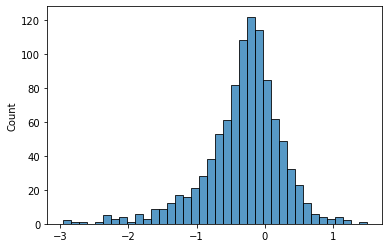

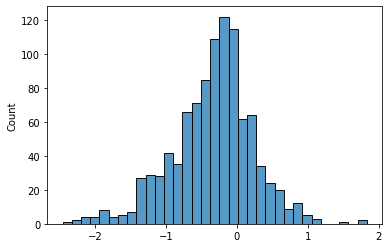

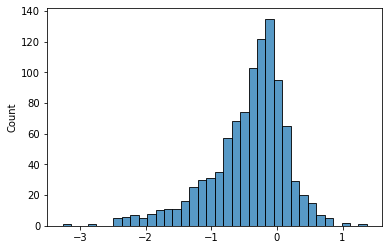

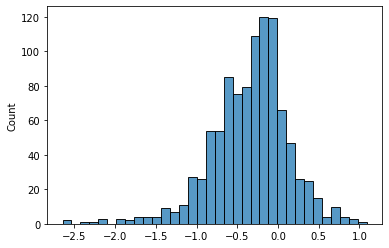

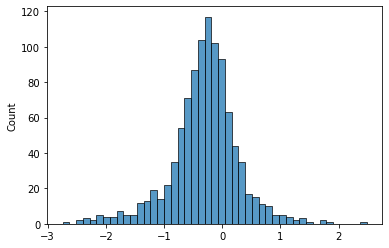

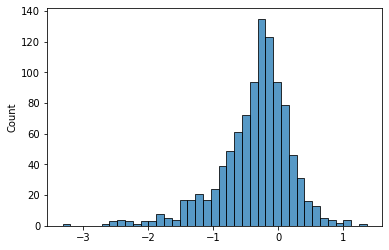

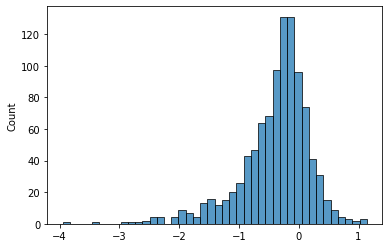

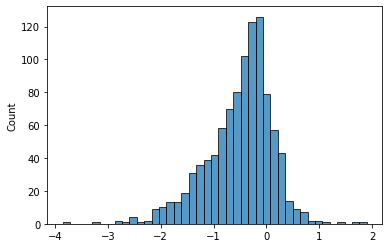

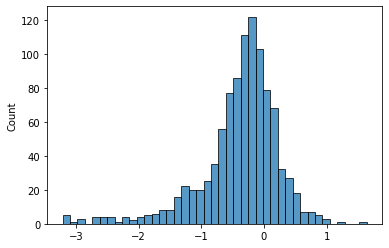

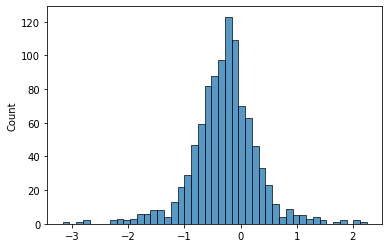

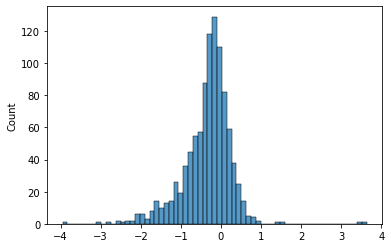

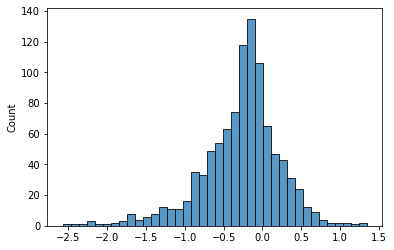

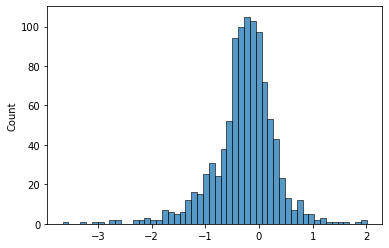

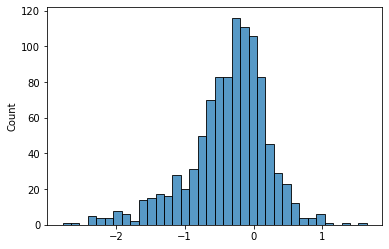

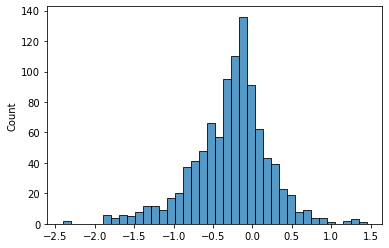

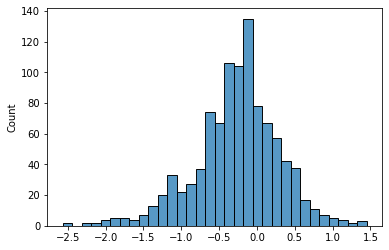

In [14]:
for i in range(16):
    sns.histplot( fil_traj['energies'][:,i] )
    plt.show()